In [1]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from kan import KAN
from fucntions import data_seq,train_seq
from sklearn.preprocessing import MinMaxScaler

In [2]:
"""
!git clone https://github.com/Han-JaeHoon/QHackathon_2024.git
%cd QHackathon_2024/
!pip install -r requirements.txt"""

'\n!git clone https://github.com/Han-JaeHoon/QHackathon_2024.git\n%cd QHackathon_2024/\n!pip install -r requirements.txt'

### Functions

In [2]:
n_qu = 4
dev = qml.device('default.qubit', wires=n_qu)

In [3]:
def ansatz(params, n_qu, all_entangled = False):
    # Length of Params : 3 * num_qubit
    for i in range(n_qu):
        qml.RX(params[:, 3*i], i)
        qml.RY(params[:, 3 * i + 1], i)
        qml.RZ(params[:, 3 * i + 2], i)
    for i in range(n_qu - 1):
        qml.CNOT([i, i + 1])
    if all_entangled:
        qml.CNOT([n_qu - 1, 0])

def embedding(params, n_qu):
    '''
    embedding layer
    '''
    n = n_qu
    for i in range(n):
        qml.Hadamard(i)
        qml.RZ(2.0 * params[:,i], i)
    
    for i in range(n - 1):
        qml.IsingZZ(2.0 * params[:,n + i] ,[i , i + 1])

# def embedding(params, n_qu, is_first):
#     for i in range(n_qu):
#         qml.Hadamard(wires=i if is_first else i+n_qu)
#         qml.RZ(2.0*params[:,i], wires=i if is_first else i+n_qu)

#     for i in range(n_qu-1):
#         qml.IsingZZ(2.0*params[:, i] ,wires = [i if is_first else i+n_qu, i+1 if is_first else i+n_qu+1])

@qml.qnode(dev, interface="torch")
def fidelity(vec1, vec2, n_qu):
    '''
        Args:
            vec1 : list, (2n - 1)개의 element로 이루어진 vector
            vec2 : list, (2n - 1)개의 element로 이루어진 vector
    '''
    embedding(vec1, n_qu) # Phi(x1) circuit 적용
    qml.adjoint(embedding)(vec2, n_qu) # Phi^t(x2) 적용
    return qml.probs()

@qml.qnode(device=dev, interface='torch')
def quantum_layer_Z(mapped_data1, mapped_data2, parameter1, parameter2, n_qu):
    embedding(params=mapped_data1, n_qu=n_qu) #, is_first=True)
    qml.Barrier()
    ansatz(params=parameter1, n_qu = n_qu)
    qml.Barrier()
    embedding(params=mapped_data2, n_qu=n_qu) #, is_first=True)
    qml.Barrier()
    ansatz(params=parameter2, n_qu = n_qu)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qu)]

@qml.qnode(device=dev, interface='torch')
def quantum_layer_prob(mapped_data1, mapped_data2, parameter1, parameter2, n_qu):
    embedding(params=mapped_data1, n_qu=n_qu) #, is_first=True)
    qml.Barrier()
    ansatz(params=parameter1, n_qu=n_qu)
    qml.Barrier()
    embedding(params=mapped_data2, n_qu=n_qu) #, is_first=True)
    qml.Barrier()
    ansatz(params=parameter2, n_qu = n_qu)
    return [qml.expval((qml.PauliZ(i)+qml.Identity(i))/2) for i in range(n_qu)]


(<Figure size 2800x500 with 1 Axes>, <Axes: >)

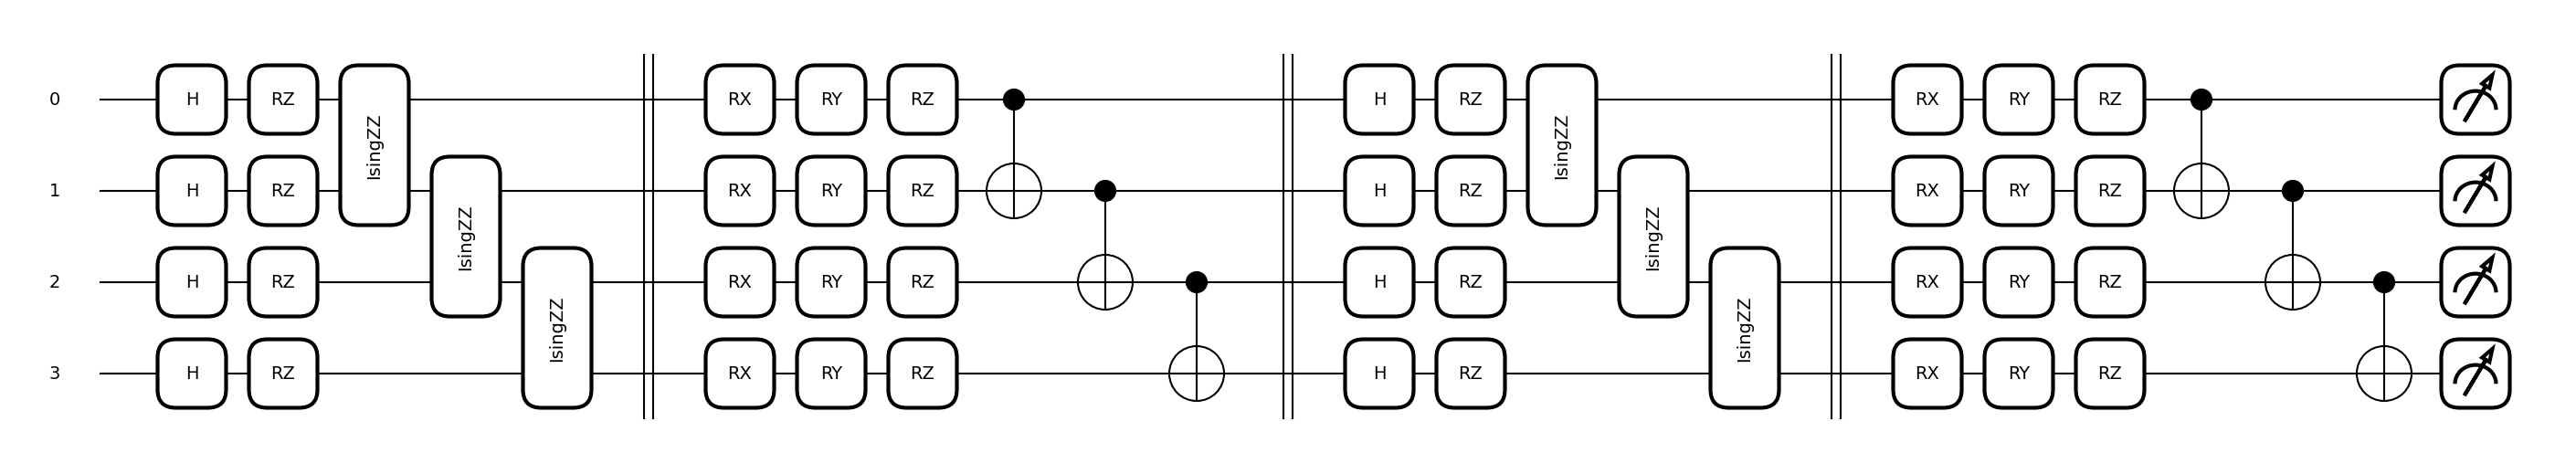

In [4]:
qml.draw_mpl(quantum_layer_prob)(mapped_data1 = torch.rand(1,2*n_qu-1), parameter1 = torch.rand(1,3*n_qu), mapped_data2 = torch.rand(1,2*n_qu-1), parameter2 = torch.rand(1,3*n_qu), n_qu=n_qu)

### NQE Class

In [5]:
class NQE(nn.Module):
    def __init__(self, n_feature, mode : str):
        '''
            Args:
                type(str) : 'FC' or 'KAN'
                n_feature(int) : # of feature
        '''
        super(NQE, self).__init__()

        self.mode = mode

        if mode == 'FC':
            self.li1 = nn.Linear(n_feature, 16)
            self.li2 = nn.Linear(16, 16)
            self.li3 = nn.Linear(16, 2 * n_feature - 1)
        
        if mode == 'KAN':
            self.n_qu = n_feature
            self.linear1 = KAN([self.n_qu, self.n_qu * 2 + 1, self.n_qu * 2 - 1], grid = 1)
            self.quantum_layer = fidelity

    def forward_FC(self, inputs):
        inputs = self.li1(inputs)
        inputs = F.relu(inputs)
        inputs = self.li2(inputs)
        inputs = F.relu(inputs)
        inputs = self.li3(inputs)
        inputs = 2 * torch.pi * F.relu(inputs)
        ## Quantum Layer 추가 필요
        return inputs # Quantum Layer의 output을 리턴

    def forwad_KAN(self, inputs):
        input1 = inputs[0]
        input2 = inputs[1]
        input1 = self.linear1(input1)
        input2 = self.linear1(input2)
        output = self.quantum_layer(input1, input2, self.n_qu)[ : , 0]
        return output

    def forward(self, inputs):
        if self.mode == 'FC':
            return self.forward_FC(inputs)
        if self.mode == 'KAN':
            return self.forwad_KAN(inputs)
    

#### NQE Train

In [48]:
df = pd.read_csv('./dataset.csv')

In [49]:
nqe_train = 250

nqe_y_train = torch.tensor(df['nat_demand'].to_numpy()[:nqe_train]).to(torch.float)
nqe_x_train = torch.tensor(df[sorted("T2M_toc	QV2M_toc TQL_toc W2M_toc T2M_san QV2M_san TQL_san W2M_san T2M_dav QV2M_dav TQL_dav W2M_dav".split())].to_numpy()[:nqe_train]).to(torch.float)

nqe_xs_train = torch.tensor([(nqe_x_train[:,3 * i : 3 * i + 3].sum(dim=1)/3).tolist() for i in range(4)]).T
print(nqe_xs_train[1])
nqe_y_train = (nqe_y_train-nqe_y_train.min())/(nqe_y_train.max()-nqe_y_train.min())


tensor([1.7476e-02, 2.3959e+01, 3.5131e-02, 1.2807e+01])


In [50]:
nqe_train_list = []
nqe_train_label_list = []
nqe_test_list = []
nqe_test_label_list = []

for i in range(nqe_train-1):
    nqe_train_data = torch.stack([nqe_xs_train, torch.concat([nqe_xs_train[( i + 1 ) : ],nqe_xs_train[:(i+1)]])])
    nqe_train_list.append(nqe_train_data)
    nqe_label_data = torch.stack([nqe_y_train,torch.concat([nqe_y_train[(i+1):],nqe_y_train[:(i+1)]])])
    nqe_train_label_list.append(nqe_label_data)

In [51]:
nqe_train_data = torch.concat(nqe_train_list, dim = 1)
nqe_train_label = torch.concat(nqe_train_label_list, dim = 1)

In [85]:
nqe_train_data.shape

torch.Size([2, 62250, 4])

In [52]:
from torch import optim
pretrain_data = data_seq(nqe_train_data, nqe_train_label)
nqe_train_loader, nqe_test_loader = pretrain_data.split_data(batch_size = 64, seq_first = True)
my_nqe = NQE(n_qu, 'KAN')
optimizer = optim.Adam(my_nqe.parameters(),lr = 0.005)

def criterion(pred, label):
    return -torch.sum(torch.log(1-pred)*(label[:,0]-label[:,1])**2 + torch.log(pred)*(1-(label[:,0]-label[:,1])**2))/len(pred)

In [53]:
pretrain_seq = train_seq(my_nqe, nqe_train_loader, nqe_test_loader)
pretrain_seq.train(3, optimizer, criterion, seq_first = True)

epoch : 1 loss :1.4440494775772095 loss_test = 1.0492675304412842
epoch : 2 loss :1.0303434133529663 loss_test = 1.0218679904937744
epoch : 3 loss :1.0075324773788452 loss_test = 0.9937018156051636


([1.4440494775772095, 1.0303434133529663, 1.0075324773788452],
 [1.0492675304412842, 1.0218679904937744, 0.9937018156051636])

In [54]:
pretrain_seq.train(5, optimizer, criterion, seq_first = True)

epoch : 1 loss :0.9079919457435608 loss_test = 0.8435789942741394
epoch : 2 loss :0.6604340672492981 loss_test = 0.5227009057998657
epoch : 3 loss :0.3792859613895416 loss_test = 0.36090975999832153
epoch : 4 loss :0.36124271154403687 loss_test = 0.3644709289073944
epoch : 5 loss :0.3618600070476532 loss_test = 0.35899877548217773


([0.9079919457435608,
  0.6604340672492981,
  0.3792859613895416,
  0.36124271154403687,
  0.3618600070476532],
 [0.8435789942741394,
  0.5227009057998657,
  0.36090975999832153,
  0.3644709289073944,
  0.35899877548217773])

In [55]:
pretrain_seq.train(3, optimizer, criterion, seq_first = True)

epoch : 1 loss :0.36128464341163635 loss_test = 0.3673866093158722
epoch : 2 loss :0.36075925827026367 loss_test = 0.3691498935222626
epoch : 3 loss :0.3596438765525818 loss_test = 0.3624372184276581


([0.36128464341163635, 0.36075925827026367, 0.3596438765525818],
 [0.3673866093158722, 0.3691498935222626, 0.3624372184276581])

### NQE Import

In [6]:
sg_nqe = NQE(n_qu, mode = 'KAN')
sg_nqe.load_state_dict(torch.load('model_001_kan_5_purefidelity_final.pth'))

<All keys matched successfully>

### GRU Class

In [13]:
class QGRU(nn.Module):
    def __init__(self, n_qu, nqe_model = None):
        self.n_qu = n_qu
        super(QGRU, self).__init__()
        for i in range(2):
            setattr(self,f'ql{i}', quantum_layer_prob)
        self.ql2 = quantum_layer_Z
        self.cls_layer = nn.Sequential(nn.Linear(n_qu,8),nn.Dropout(0.0) ,nn.ReLU(),nn.Linear(8,1)).to(torch.float32)

        self.nqe_model = nqe_model

        self.ansatz_params_11 = nn.Parameter(torch.rand([1,3*n_qu],dtype = torch.float32),requires_grad=True)
        self.ansatz_params_12 = nn.Parameter(torch.rand([1,3*n_qu],dtype = torch.float32),requires_grad=True)
        self.ansatz_params_21 = nn.Parameter(torch.rand([1,3*n_qu],dtype = torch.float32),requires_grad=True)
        self.ansatz_params_22 = nn.Parameter(torch.rand([1,3*n_qu],dtype = torch.float32),requires_grad=True)
        self.ansatz_params_31 = nn.Parameter(torch.rand([1,3*n_qu],dtype = torch.float32),requires_grad=True)
        self.ansatz_params_32 = nn.Parameter(torch.rand([1,3*n_qu],dtype = torch.float32),requires_grad=True)

    def nQE_layer(self, input):
        if self.nqe_model == None:
            n_qu = input.shape[1]
            n_batch = input.shape[0]
            for i in range(n_qu-1):
                input = torch.cat(([input,((torch.pi-input[:,i])*(torch.pi-input[:,i+1])).reshape(n_batch,1)]),1)
            return input
        
        if self.nqe_model.mode == 'KAN':
            result = self.nqe_model.linear1(input)
            
        
        if self.nqe_model.mode == 'FC':
            pass
            # result = self.nqe_model.

            # self.li1 = nn.Linear(n_feature, 16)
            # self.li2 = nn.Linear(16, 16)
            # self.li3 = nn.Linear(16, 2 * n_feature - 1)
        return result

    def forward(self, inputs, return_hidden_list = False):
        batch = inputs.shape[0]
        seq_len = inputs.shape[1]
        n_qu = inputs.shape[2]
        inputs = inputs.permute(1,0,2)
        h0 = torch.zeros(batch,n_qu)
        input0 = self.nQE_layer(inputs[0])
        r0 = torch.stack(self.ql0(mapped_data1 = input0, mapped_data2 = self.nQE_layer(h0), parameter1 = self.ansatz_params_11, parameter2 = self.ansatz_params_12, n_qu = n_qu),dim=1)
        z0 = torch.stack(self.ql1(mapped_data1 = input0, mapped_data2 = self.nQE_layer(h0), parameter1 = self.ansatz_params_21, parameter2 = self.ansatz_params_22, n_qu = n_qu),dim=1)
        n0 = torch.stack(self.ql2(mapped_data1 = input0, mapped_data2 = self.nQE_layer(r0), parameter1 = self.ansatz_params_31, parameter2 = self.ansatz_params_32, n_qu = n_qu),dim=1)
        hidden = (1-z0)*n0+z0*h0
        if return_hidden_list:
            hidden_list = hidden
        for input in inputs[1:]:
            input = self.nQE_layer(input)
            h = hidden
            ah = self.nQE_layer(hidden)
            r = torch.stack(self.ql0(mapped_data1 = input, mapped_data2 = ah, parameter1 = self.ansatz_params_11, parameter2 = self.ansatz_params_12, n_qu = n_qu),dim=1)
            z = torch.stack(self.ql1(mapped_data1 = input, mapped_data2 = ah, parameter1 = self.ansatz_params_21, parameter2 = self.ansatz_params_22, n_qu = n_qu),dim=1)
            n = torch.stack(self.ql2(mapped_data1 = input, mapped_data2 = self.nQE_layer(r), parameter1 = self.ansatz_params_31, parameter2 = self.ansatz_params_32, n_qu = n_qu),dim=1)
            hidden = (1-z)*n+z*h
            if return_hidden_list:
                hidden_list = torch.concat([hidden_list, hidden])
        if return_hidden_list:
            hidden_list = torch.reshape(hidden_list,[batch, seq_len,-1])
            return hidden_list
        return self.cls_layer(hidden.to(torch.float32))

#### GRU Train

In [14]:
### GRU Train Set

import pickle
with open('train_data_NQE.pkl','rb') as file:
    data_dict = pickle.load(file)

train_loader,test_loader = data_dict['train'],data_dict['test']

In [15]:
import torch.optim as optim

GRU_model = QGRU(4, sg_nqe).to(torch.float32)

criterion = nn.MSELoss()
optimizer = optim.Adam(GRU_model.parameters(), lr=0.002)

In [16]:
train_corpus = train_seq(GRU_model, train_loader, test_loader)

In [17]:
train_loss_list, test_loss_list = train_corpus.train(500, optimizer, criterion)

epoch : 1 loss :0.3845905363559723 loss_test = 0.33906134963035583
epoch : 2 loss :0.288218230009079 loss_test = 0.24310192465782166
epoch : 3 loss :0.18919284641742706 loss_test = 0.14953382313251495
epoch : 4 loss :0.12078138440847397 loss_test = 0.09847287833690643
epoch : 5 loss :0.0732792392373085 loss_test = 0.05325343459844589
epoch : 6 loss :0.03915749117732048 loss_test = 0.03135336935520172
epoch : 7 loss :0.03250236436724663 loss_test = 0.03148747608065605
epoch : 8 loss :0.024135716259479523 loss_test = 0.02029576525092125
epoch : 9 loss :0.013798083178699017 loss_test = 0.013571351766586304
epoch : 10 loss :0.009376867674291134 loss_test = 0.010739466175436974
epoch : 11 loss :0.007599431090056896 loss_test = 0.009576822631061077
epoch : 12 loss :0.0069439951330423355 loss_test = 0.009127605706453323
epoch : 13 loss :0.006632095668464899 loss_test = 0.00899340957403183
epoch : 14 loss :0.006496587302535772 loss_test = 0.008925491943955421
epoch : 15 loss :0.006397387012839

KeyboardInterrupt: 

### To CSV + Plot

In [18]:
train_loss_list, test_loss_list = train_corpus.train_loss_list ,train_corpus.test_loss_list

In [19]:
def get_data(model,train_loader,test_loader):
    pred_list = []
    train_label_list = []
    test_pred_list = []
    test_label_list = []
    for data,label in train_loader:
        pred = model(data)
        pred_list.append(pred.detach().numpy())
        train_label_list.append(label.numpy())
    for data,label in test_loader:
        pred = model(data)
        test_pred_list.append(pred.detach().numpy())
        test_label_list.append(label.numpy())

    return list(np.concatenate(pred_list).reshape(-1)),list(np.concatenate(train_label_list).reshape(-1)),list(np.concatenate(test_pred_list).reshape(-1)),list(np.concatenate(test_label_list).reshape(-1))

In [20]:
pred_list,train_label_list,test_pred_list,validation_label = get_data(GRU_model, train_loader, test_loader)

In [28]:
import pandas as pd

# 각 리스트의 길이 확인
lengths = [len(train_loss_list), len(test_loss_list), len(pred_list), len(train_label_list), len(test_pred_list), len(validation_label)]
max_length = max(lengths)

# 리스트의 길이를 최대 길이로 맞추기 (None으로 패딩)
def pad_list(lst, max_length):
    return lst + [None] * (max_length - len(lst))

train_loss_list = pad_list(train_loss_list, max_length)
test_loss_list = pad_list(test_loss_list, max_length)
pred_list = pad_list(pred_list, max_length)
train_label_list = pad_list(train_label_list, max_length)
test_pred_list = pad_list(test_pred_list, max_length)
validation_label = pad_list(validation_label, max_length)

# 데이터 프레임 생성
data_set = pd.DataFrame({
    'train_loss': train_loss_list,
    'test_loss': test_loss_list,
    'train_predict': pred_list,
    'train_label': train_label_list,
    'validation_predict': test_pred_list,
    'validation_label': validation_label
})

data_set.to_csv('./result_data/qGRU_NQEKAN_cor_data.csv',index=False)

In [22]:
torch.save(GRU_model.state_dict(), 'model_04_KAN_qGRU.pth')

(0.0, 0.025)

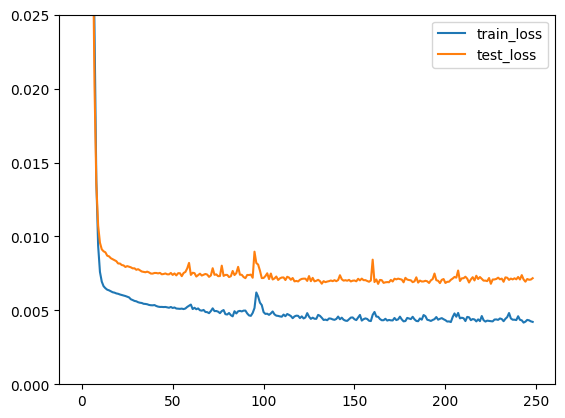

In [27]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list, label = 'train_loss')
plt.plot(test_loss_list, label = 'test_loss')
plt.legend()
plt.ylim([0, 0.025])

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list[25:])
plt.plot(test_loss_list[25:])
plt.ylim([0, 0.5])

In [ ]:
def decoding(input,max_value):
  return (np.max(df['nat_demand'])-np.min(df['nat_demand']))/max_value*input+np.min(df['nat_demand'])

for feature,label in test_loader:
    pred = decoding(GRU_model(feature),2*3.14)
    true = decoding(label,2*3.14)
    print(nn.MSELoss()(true,pred))
    break